### Set parameters

In [7]:
type = "real_simul"
device = 'nano'
model = "densenet201"
date_label = "0106"

# Import

In [8]:
# 기본 세팅
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.stats import gaussian_kde
from matplotlib import colors as mpl_colors
import os
import argparse
from datetime import datetime
from glob import glob
from itertools import product, groupby
from mpl_toolkits.mplot3d import Axes3D
import re

# Font & Color

##### TODO
- font download

In [9]:
# font = {'family': 'Tahoma'}
# font = {'family': 'Times New Roman'}

# plt.rc('font', **font)

colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']
grid_color = 'gainsboro'

In [10]:
def layerNum(model:str) -> int:
    if model == "densenet201" :
        return 306
    elif model == "resnet152" :
        return 206
    elif model == "enetb0" :
        return 136
    elif model == "csmobilenet-v2" :
        return 81
    elif model == "squeezenet" :
        return 50
    elif model == "yolov7" :
        return 143
    elif model == "yolov7-tiny" :
        return 99
    elif model == "yolov4" :
        return 162
    elif model == "yolov4-tiny" :
        return 38
    elif model == "resnet10" :
        return 17
    elif model == "yolov2-tiny" :
        return 16
    else :
        print("Unknown model: ", model)
        return 0

def maxCore(device:str) -> int:
    if device == "nano":
        return 4
    if device == "orin":
        return 10
    else:
        print("Unknown device: ", device)
        return 0

### Options

In [11]:
save_formats = ['png', 'pdf', 'svg']
devices = ['nano', 'orin']
types = ["toy_simul", "real_simul", "real_exp"]
models = ['densenet201', 'resnet152', 'enetb0', 'csmobilenet-v2', 'squeezenet', 
          'yolov7', 'yolov7-tiny', 'yolov4', 'yolov4-tiny', 'resnet10', 'yolov2-tiny']

max_cores = maxCore(device)
if type not in types:
    print("Unknown type: ", type)
layer_num = layerNum(model)
if not os.path.exists(f"../../csv/{date_label}"):
    print(f"Invalid date: {date_label}")

In [12]:
for save_format in save_formats:
    directory_path = f'./{save_format}'
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
        print(f"디렉터리 '{directory_path}' 생성 완료!")
    else:
        print(f"디렉터리 '{directory_path}'가 이미 존재합니다.")

디렉터리 './png'가 이미 존재합니다.
디렉터리 './pdf'가 이미 존재합니다.
디렉터리 './svg'가 이미 존재합니다.


### Load csv & Dataframe 생성

##### 1. toy_simul

In [13]:
if type == "toy_simul":
    models = ["GPU >>> CPU", "GPU >> CPU", "GPU > CPU", "GPU > CPU | GPU < CPU"]
    # model = models[2]
    max_cores = 10
    # max_cores = maxCore(device)
    if type not in types:
        print("Unknown type: ", type)
    contention_overhead_percent = 10

In [14]:
if type == "toy_simul":
    if model == "GPU >>> CPU":
        # GPU >>> CPU
        cpu_inference_list = [200,400,350,460,570,330,250,290,310,300]
        gpu_inference_list = [1,3,2,5,7,8,1,3,4,1]
    elif model == "GPU >> CPU":
        # GPU >>> CPU
        cpu_inference_list = [100,200,150,260,270,130,50,90,110,30]
        gpu_inference_list = [1,3,2,5,7,8,1,3,4,1]
    elif model == "GPU > CPU":
        # GPU > CPU
        cpu_inference_list = [10,20,15,26,27,13,5,9,11,3]
        gpu_inference_list = [1,3,2,5,7,8,1,3,4,1]
    elif model == "GPU > CPU | GPU < CPU":
        # # GPU CPU 반반 (앞이 GPU 효율 좋음)
        cpu_inference_list = [10,20,15,26,27,13,5,9,11,3]
        gpu_inference_list = [1,3,2,5,7,18,14,15,18,5]
    else: print("Unknown mode")
    layer_num = len(cpu_inference_list)

In [15]:
if type == "toy_simul":
    e_preprocess = 0
    e_postprocess = 0
    e_inference_cpu = sum(cpu_inference_list)
    e_inference_gpu = sum(gpu_inference_list)

In [16]:
if type == "toy_simul":
    # 데이터 저장을 위한 딕셔너리
    average_execution_times = {}
    throughput = {}
    block_losses = {}
    accel_gains = {}
    pre_components = {}
    infer_components = {}
    post_components = {}
    block_components = {}

    labels = ['Seq\n(Full CPU)', 'TPA\n(Full CPU)', 'DPA\n(Full CPU)',
              'Seq\n(Full GPU)', 'TPA\n(Full GPU)', 'DPA\n(Full GPU)']

In [17]:
if type == "toy_simul":
    # Calculations for Sequential (Full CPU)
    e_inference_cpu = sum(cpu_inference_list)
    delay_seq_cpu = e_preprocess + e_inference_cpu + e_postprocess
    average_execution_times["Seq\n(Full CPU)"] = delay_seq_cpu

    throughput["Seq\n(Full CPU)"] = 1 / delay_seq_cpu * 1000

    block_loss_seq_cpu = 0
    block_losses["Seq\n(Full CPU)"] = block_loss_seq_cpu



    # Calculations for Pipeline (Full CPU)
    max_stage_cpu = max(e_preprocess, e_inference_cpu, e_postprocess)
    if max_stage_cpu == e_preprocess:
        pipeline_stall_cpu = e_preprocess - e_inference_cpu
    elif max_stage_cpu == e_inference_cpu:
        pipeline_stall_cpu = e_inference_cpu - e_preprocess
    else:
        pipeline_stall_cpu = e_postprocess - e_preprocess + e_postprocess - e_inference_cpu
    block_losses["TPA\n(Full CPU)"] = pipeline_stall_cpu

    delay_tpa_cpu = e_preprocess + e_inference_cpu + e_postprocess + pipeline_stall_cpu
    average_execution_times["TPA\n(Full CPU)"] = delay_tpa_cpu

    throughput_tpa_cpu = 1 / max_stage_cpu * 1000
    throughput["TPA\n(Full CPU)"] = throughput_tpa_cpu


    # Calculations for Data-parallel (Full CPU)
    contention_overhead_cpu = (delay_seq_cpu * contention_overhead_percent) / 100
    # block_losses["DPA\n(Full CPU)"] = contention_overhead_cpu

    delay_dpa_cpu = delay_seq_cpu + contention_overhead_cpu
    throughput_dpa_cpu = 1 / (delay_dpa_cpu / max_cores) * 1000
    throughput["DPA\n(Full CPU)"] = throughput_dpa_cpu

    block_loss_dpa_cpu = 0
    block_losses["DPA\n(Full CPU)"] = block_loss_dpa_cpu

    delay_dpa_cpu = delay_dpa_cpu + block_loss_dpa_cpu
    average_execution_times["DPA\n(Full CPU)"] = delay_dpa_cpu


    # Calculations for Sequential (Full GPU)
    e_inference_gpu = sum(gpu_inference_list)
    delay_seq_gpu = e_preprocess + e_inference_gpu + e_postprocess
    average_execution_times["Seq\n(Full GPU)"] = delay_seq_gpu

    throughput_seq_gpu = 1 / delay_seq_gpu * 1000
    throughput["Seq\n(Full GPU)"] = throughput_seq_gpu

    block_loss_seq_gpu = 0
    block_losses["Seq\n(Full GPU)"] = block_loss_seq_gpu


    # Calculations for Pipeline (Full GPU)
    max_stage_gpu = max(e_preprocess, e_inference_gpu, e_postprocess)
    if max_stage_gpu == e_preprocess:
        pipeline_stall_gpu = e_preprocess - e_inference_gpu
    elif max_stage_gpu == e_inference_gpu:
        pipeline_stall_gpu = e_inference_gpu - e_preprocess
    else:
        pipeline_stall_gpu = e_postprocess - e_preprocess + e_postprocess - e_inference_gpu
    block_losses["TPA\n(Full GPU)"] = pipeline_stall_gpu

    delay_tpa_gpu = e_preprocess + e_inference_gpu + e_postprocess + pipeline_stall_gpu
    average_execution_times["TPA\n(Full GPU)"] = delay_tpa_gpu

    throughput_tpa_gpu = 1 / max_stage_gpu * 1000
    throughput["TPA\n(Full GPU)"] = throughput_tpa_gpu


    # Calculations for Data-parallel (Full GPU)
    contention_overhead_gpu = (delay_seq_gpu * contention_overhead_percent) / 100

    delay_dpa_gpu = delay_seq_gpu + contention_overhead_gpu
    throughput_dpa_gpu = 1 / max(delay_dpa_gpu / max_cores, e_inference_gpu) * 1000
    throughput["DPA\n(Full GPU)"] = throughput_dpa_gpu

    block_loss_dpa_gpu = e_inference_gpu * (max_cores-1) - (e_preprocess+e_postprocess)
    if block_loss_dpa_gpu < 0 : block_loss_dpa_gpu = 0
    block_losses["DPA\n(Full GPU)"] = block_loss_dpa_gpu

    delay_dpa_gpu = delay_dpa_gpu + block_loss_dpa_gpu
    average_execution_times["DPA\n(Full GPU)"] = delay_dpa_gpu

    accel_gain = e_inference_cpu - e_inference_gpu
    accel_gains["Seq\n(Full GPU)"] = accel_gain
    accel_gains["TPA\n(Full GPU)"] = accel_gain
    accel_gains["DPA\n(Full GPU)"] = accel_gain

    for label in labels:
        pre_components[label] = e_preprocess
        if label[-4:-1] == "CPU":
            infer_components[label] = e_inference_cpu
        else:
            infer_components[label] = e_inference_gpu
        post_components[label] = e_postprocess
        block_components[label] = block_losses[label]


2. real_simul

In [18]:
if type == 'real_simul':
    # device = 'nano'
    # type = "real_simul"
    # model = "densenet201"
    # date_label = "0107"

    max_cores = maxCore(device)
    if type not in types:
        print("Unknown type: ", type)
    layer_num = layerNum(model)
    if not os.path.exists(f"../../csv/{date_label}"):
        print(f"Invalid date: {date_label}")

    contention_overhead_percent = 0

In [21]:
if type == 'real_simul':
    date_label = "0107"
    cpu_file_path = f'../../csv/{date_label}/layer_time/{model}/cpu_raw_data_01blas.csv'
    gpu_file_path = f'../../csv/{date_label}/layer_time/{model}/gpu_raw_data.csv'

In [22]:
if type == 'real_simul':
    cpu_data = pd.read_csv(cpu_file_path)

    e_preprocess = np.mean(cpu_data["e_preprocess"])
    e_postprocess = np.mean(cpu_data["e_postprocess"])

    layer_columns = [col for col in cpu_data.columns if col.startswith('layer')]
    layer_num = 0
    layer_averages_cpu = {}
    for col in layer_columns:
        # 열 제목에서 숫자만 추출
        col_number = int(re.search(r'\d+', col).group())
        # 해당 열의 평균 계산 및 저장
        layer_averages_cpu[col_number] = cpu_data[col].mean()
        if layer_num < col_number : layer_num = col_number

        
    gpu_data = pd.read_csv(gpu_file_path)

    layer_columns = [col for col in gpu_data.columns if col.startswith('layer')]
    layer_num = 0
    layer_averages_gpu = {}
    for col in layer_columns:
        # 열 제목에서 숫자만 추출
        col_number = int(re.search(r'\d+', col).group())
        # 해당 열의 평균 계산 및 저장
        layer_averages_gpu[col_number] = gpu_data[col].mean()
        if layer_num < col_number : layer_num = col_number

    # CPU와 GPU 인퍼런스 리스트 생성
    cpu_inference_list = list(layer_averages_cpu.values())
    gpu_inference_list = list(layer_averages_gpu.values())

##### [TODO]
##### 아래 두 블럭 무슨 기능하는지 확인하기
###### reference code 본 결과, layer_time 정보로 simulation으로 계산하는 부분으로 보임

In [24]:
# Preprocess Layer와 Postprocess Layer 앞 뒤에 넣기
layer_num = len(cpu_inference_list)
print(e_preprocess, e_postprocess)
cpu_inference_list.insert(0, e_preprocess)
cpu_inference_list.append(e_postprocess)
gpu_inference_list.insert(0, 0)
gpu_inference_list.append(0)


# acceleration_type 앞 뒤에 CPU (0) 넣기
# [0,M] & [start, M] 구성 찾기
all_results = []
acceleration_type = []

# 모든 start 값에 대한 배열 생성
for start in range(0, 1):
    result = []
    for i in range(start, layer_num):
        row = [0] + [0] * start + [1] * (i - start + 1) + [0] * (layer_num - (i + 1)) + [0]
        result.append(row)
        acceleration_type.append(row)
    all_results.append(result)
# print(acceleration_type)
acceleration_type.sort(key=lambda x: (x.count(1), next((i for i, v in enumerate(x) if v == 1), layer_num+2)))
# print(acceleration_type)

layer_num = len(cpu_inference_list)
print(len(acceleration_type))
print(len(acceleration_type[0]))
print(layer_num)

14.456428571428575 0.010142857142857143
308
310
310


In [26]:
num_thread = max_cores
num_repeat = 100  # 반복 횟수

output_cycle_time = []
output_frame_rate = []
max_execution_time_list = []
min_execution_time_list = []
avg_execution_time_list = []
total_execution_time_list = []
throughput_list = []
acceleration_gain_list = []
block_time_list = []
num_accelerated_layer_list = []

for test_case in range(0, len(acceleration_type)):
    # target_case 가져오기
    target_case = acceleration_type[test_case]
    count_of_ones = target_case.count(1)
    num_accelerated_layer_list.append(count_of_ones)
    # if test_case == 1: print(target_case)
    
    # 연속된 0과 1을 segment 단위로 묶기
    segments = [list(g) for k, g in groupby(target_case)]
    # if test_case == 1: print(segments)
    
    # 각 segment의 delay 및 타입 계산
    segment_delays = []
    segment_types = []
    start_idx = 0
    
    for segment in segments:
        segment_type = segment[0]  # 0 (CPU) 또는 1 (GPU)
        segment_length = len(segment)
        
        # 해당 segment의 delay 계산
        if segment_type == 0:
            delay = sum(cpu_inference_list[start_idx:start_idx + segment_length])
            segment_types.append("cpu")
        else:
            delay = sum(gpu_inference_list[start_idx:start_idx + segment_length])
            segment_types.append("gpu")
        
        segment_delays.append(delay)
        start_idx += segment_length  # 다음 segment의 시작 인덱스 업데이트
    
    # 결과 출력
    # for i, (delay, segment_type) in enumerate(zip(segment_delays, segment_types)):
    #     print(f"Segment {i + 1}: Type = {segment_type}, Delay = {delay}")
    
    segment_type = segment_types
    segment_delay = segment_delays
    
    regular_output_list = []
    total_delay_ = sum(segment_delay)
    
    for input_pattern in range(0, 1):
        data_arrival_interval = input_pattern
    
        task_start_time = [i * data_arrival_interval for i in range(num_thread * num_repeat)]  # [0, 5, 10, 15, 20, 25]
        gpu_available_time = [[[0, float('inf')]] for _ in range(num_thread)]
        segment_end_times = task_start_time[:num_thread]  # 각 스레드의 세그먼트 end_time 초기화
        
        # 시각화를 위한 데이터 수집
        execution_data = {i: [] for i in range(num_thread)}  # 각 스레드의 작업 시작과 끝 시간 저장
        
        for repeat in range(num_repeat):
            # print(f"\nRepeat {repeat + 1} 시작:")
            # 각 세그먼트를 순회
            for k in range(len(segment_type)):
                for i in range(num_thread):
                    # 첫 번째 세그먼트의 시작 시간 조정
                    if k == 0:
                        start_time = max(segment_end_times[i], task_start_time[i + num_thread * repeat])
                    else:
                        start_time = segment_end_times[i]
                        
                    end_time = start_time + segment_delay[k]
        
                    if segment_type[k] == 'gpu':
                        start_time = max(start_time, gpu_available_time[i][0][0])
                        end_time = start_time + segment_delay[k]
        
                        for interval in gpu_available_time[i]:
                            gpu_use_time = end_time - start_time
                            # print(interval[1]-interval[0])
                            if (interval[1]-interval[0]) < gpu_use_time:
                                pass
                            else:
                                start_time = max(start_time, interval[0])
                                end_time = start_time + segment_delay[k]
                                break
                        
                        # 시각화 데이터에 추가
                        execution_data[i].append((start_time, end_time, segment_type[k]))
        
                        
                        # 해당 스레드의 gpu_available_time에서 start_time 이전 값을 삭제
                        new_available_time = []
                        for interval in gpu_available_time[i]:
                            if interval[1] > start_time:
                                if interval[0] < start_time:
                                    new_available_time.append([start_time, interval[1]])
                                else:
                                    new_available_time.append(interval)
                        gpu_available_time[i] = new_available_time
        
                        # 모든 스레드에 대해 gpu_available_time을 업데이트
                        for j in range(num_thread):
                            new_available_time = []
                            for interval in gpu_available_time[j]:
                                if end_time <= interval[0] or start_time >= interval[1]:
                                    new_available_time.append(interval)
                                else:
                                    if interval[0] < start_time:
                                        new_available_time.append([interval[0], start_time])
                                    if interval[1] > end_time:
                                        new_available_time.append([end_time, interval[1]])
                            gpu_available_time[j] = new_available_time
        
                    elif segment_type[k] == 'cpu':
                        # 시각화 데이터에 추가
                        execution_data[i].append((start_time, end_time, segment_type[k]))
        
                        # 현재 스레드의 gpu_available_time에서 end_time 이하의 구간을 삭제
                        new_available_time = []
                        for interval in gpu_available_time[i]:
                            if interval[1] > end_time:
                                if interval[0] < end_time:
                                    new_available_time.append([end_time, interval[1]])
                                else:
                                    new_available_time.append(interval)
                        gpu_available_time[i] = new_available_time
        
                    # 현재 세그먼트의 종료 시간을 기록하여 다음 세그먼트 시작 시간을 결정
                    segment_end_times[i] = end_time
                    # print(f"스레드 {i + 1}의 {segment_type[k]} 세그먼트 후 gpu_available_time:", gpu_available_time)
        
        # 각 스레드의 end_time 기록을 위한 초기화
        thread_end_times = [0] * num_thread  # 각 스레드의 마지막 end_time 기록
        
        # Start time, end time, and end-to-end delay lists 초기화
        release_time_list = []
        start_time_list = []
        end_time_list = []
        end_to_end_delay_list = []
        
        # End-to-end delay 계산 및 리스트에 저장
        for repeat in range(num_repeat):
            for thread in range(num_thread):
                # 각 task의 첫 번째 세그먼트의 start_time과 마지막 세그먼트의 end_time 찾기
                task_segments = execution_data[thread][repeat * len(segment_type):(repeat + 1) * len(segment_type)]
                start_time = task_segments[0][0]
                end_time = task_segments[-1][1]
                end_to_end_delay = end_time - thread_end_times[thread]
                # print(start_time, end_time)
                
                # 리스트에 추가
                release_time_list.append(thread_end_times[thread])
                start_time_list.append(start_time)
                end_time_list.append(end_time)
                end_to_end_delay_list.append(end_to_end_delay)
        
                # 현재 스레드의 마지막 end_time 업데이트
                thread_end_times[thread] = end_time
                
                # print(f"Repeat {repeat + 1}, Thread {thread + 1} - Start: {start_time}, End: {end_time}, End-to-End Delay: {end_to_end_delay}")
        
        # 리스트 출력
        # print("\nRelease Time List:", release_time_list)
        # print("Start Time List:", start_time_list)
        # print("End Time List:", end_time_list)
        # print("End-to-End Delay List:", end_to_end_delay_list)
        
        # Start time gap list와 end time gap list 초기화
        start_time_gap_list = []
        end_time_gap_list = []
        
        # Start time과 end time gap 계산
        for i in range(1, len(release_time_list)):
            start_time_gap = release_time_list[i] - release_time_list[i - 1]
            end_time_gap = end_time_list[i] - end_time_list[i - 1]
            
            start_time_gap_list.append(start_time_gap)
            end_time_gap_list.append(end_time_gap)
            
        max_execution_time_list.append(np.max(end_to_end_delay_list[num_repeat:]))
        min_execution_time_list.append(np.min(end_to_end_delay_list[num_repeat:]))
        avg_execution_time_list.append(np.mean(end_to_end_delay_list[num_repeat:]))
        total_execution_time = end_time_list[-1] - release_time_list[num_repeat]
        # print("here", end_time_list[-1], release_time_list[num_repeat])
        throughput = (num_repeat * num_thread) / total_execution_time * 1000
        total_execution_time_list.append(total_execution_time)
        throughput_list.append(throughput)
        # print(test_case, "-->", end_time_gap_list, end_to_end_delay_list)

        corresponding_acceleration_type = acceleration_type[test_case]

        # 합 계산
        total_inference_time = sum(
            cpu_inference_list[i] if corresponding_acceleration_type[i] == 0 else gpu_inference_list[i]
            for i in range(layer_num)
        )
        
        # blcok loss & acceleration gain
        total_cpu_time = sum(cpu_inference_list)
        acceleration_gain = total_cpu_time - total_inference_time
        acceleration_gain_list.append(acceleration_gain)
        max_execution_time = np.max(end_to_end_delay_list[num_repeat:])
        block_time = max_execution_time-total_inference_time
        block_time_list.append(block_time)
        
        print(test_case, "-->", np.max(end_to_end_delay_list[num_repeat:]), np.min(end_to_end_delay_list[num_repeat:]), np.mean(end_to_end_delay_list[num_repeat:]), "--> total_execution_time:", total_execution_time, "throughput:", throughput)
        print(test_case, total_cpu_time, max_execution_time,total_inference_time, "-->", f"가속 이득: {acceleration_gain} 블락 손실: {block_time}\n")

0 --> 754.9420000000027 754.9419999999955 754.9420000000014 --> total_execution_time: 56620.6500000001 throughput: 7.064560367992937
0 769.3984285714282 754.9420000000027 754.9419999999998 --> 가속 이득: 14.456428571428432 블락 손실: 2.9558577807620168e-12

1 --> 733.0039460317494 733.0039460317421 733.003946031745 --> total_execution_time: 54980.26841904754 throughput: 7.275337343777368
1 769.3984285714282 733.0039460317494 733.0039460317457 --> 가속 이득: 36.394482539682485 블락 손실: 3.637978807091713e-12

2 --> 730.1937587301654 730.1937587301582 730.1937587301602 --> total_execution_time: 54770.05323809535 throughput: 7.303261113534571
2 769.3984285714282 730.1937587301654 730.1937587301584 --> 가속 이득: 39.20466984126983 블락 손실: 7.048583938740194e-12

3 --> 726.2175206349275 726.2175206349202 726.2175206349212 --> total_execution_time: 54473.16148095243 throughput: 7.343065633153448
3 769.3984285714282 726.2175206349275 726.2175206349202 --> 가속 이득: 43.18090793650799 블락 손실: 7.275957614183426e-12

4 -

if type == 'real_simul':
    # 데이터 저장을 위한 딕셔너리
    average_execution_times = {}
    throughput = {}
    block_losses = {}
    accel_gains = {}
    pre_components = {}
    infer_components = {}
    post_components = {}
    block_components = {}

    labels = ['Seq\n(Full CPU)', 'TPA\n(Full CPU)', 'DPA\n(Full CPU)', 
              'Seq\n(Full GPU)', 'TPA\n(Full GPU)', 'DPA\n(Full GPU)']

if type == 'real_simul':
    # Calculations for Sequential (Full CPU)
    e_inference_cpu = sum(cpu_inference_list)
    delay_seq_cpu = e_preprocess + e_inference_cpu + e_postprocess
    average_execution_times["Seq\n(Full CPU)"] = delay_seq_cpu

    throughput["Seq\n(Full CPU)"] = 1 / delay_seq_cpu * 1000

    block_loss_seq_cpu = 0
    block_losses["Seq\n(Full CPU)"] = block_loss_seq_cpu



    # Calculations for Pipeline (Full CPU)
    max_stage_cpu = max(e_preprocess, e_inference_cpu, e_postprocess)
    if max_stage_cpu == e_preprocess:
        pipeline_stall_cpu = e_preprocess - e_inference_cpu
    elif max_stage_cpu == e_inference_cpu:
        pipeline_stall_cpu = e_inference_cpu - e_preprocess
    else:
        pipeline_stall_cpu = e_postprocess - e_preprocess + e_postprocess - e_inference_cpu
    block_losses["TPA\n(Full CPU)"] = pipeline_stall_cpu

    delay_tpa_cpu = e_preprocess + e_inference_cpu + e_postprocess + pipeline_stall_cpu
    average_execution_times["TPA\n(Full CPU)"] = delay_tpa_cpu

    throughput_tpa_cpu = 1 / max_stage_cpu * 1000
    throughput["TPA\n(Full CPU)"] = throughput_tpa_cpu


    # Calculations for Data-parallel (Full CPU)
    contention_overhead_cpu = (delay_seq_cpu * contention_overhead_percent) / 100
    # block_losses["DPA\n(Full CPU)"] = contention_overhead_cpu

    delay_dpa_cpu = delay_seq_cpu + contention_overhead_cpu
    throughput_dpa_cpu = 1 / (delay_dpa_cpu / max_cores) * 1000
    throughput["DPA\n(Full CPU)"] = throughput_dpa_cpu

    block_loss_dpa_cpu = 0
    block_losses["DPA\n(Full CPU)"] = block_loss_dpa_cpu

    delay_dpa_cpu = delay_dpa_cpu + block_loss_dpa_cpu
    average_execution_times["DPA\n(Full CPU)"] = delay_dpa_cpu


    # Calculations for Sequential (Full GPU)
    e_inference_gpu = sum(gpu_inference_list)
    delay_seq_gpu = e_preprocess + e_inference_gpu + e_postprocess
    average_execution_times["Seq\n(Full GPU)"] = delay_seq_gpu

    throughput_seq_gpu = 1 / delay_seq_gpu * 1000
    throughput["Seq\n(Full GPU)"] = throughput_seq_gpu

    block_loss_seq_gpu = 0
    block_losses["Seq\n(Full GPU)"] = block_loss_seq_gpu


    # Calculations for Pipeline (Full GPU)
    max_stage_gpu = max(e_preprocess, e_inference_gpu, e_postprocess)
    if max_stage_gpu == e_preprocess:
        pipeline_stall_gpu = e_preprocess - e_inference_gpu
    elif max_stage_gpu == e_inference_gpu:
        pipeline_stall_gpu = e_inference_gpu - e_preprocess
    else:
        pipeline_stall_gpu = e_postprocess - e_preprocess + e_postprocess - e_inference_gpu
    block_losses["TPA\n(Full GPU)"] = pipeline_stall_gpu

    delay_tpa_gpu = e_preprocess + e_inference_gpu + e_postprocess + pipeline_stall_gpu
    average_execution_times["TPA\n(Full GPU)"] = delay_tpa_gpu

    throughput_tpa_gpu = 1 / max_stage_gpu * 1000
    throughput["TPA\n(Full GPU)"] = throughput_tpa_gpu


    # Calculations for Data-parallel (Full GPU)
    contention_overhead_gpu = (delay_seq_gpu * contention_overhead_percent) / 100

    delay_dpa_gpu = delay_seq_gpu + contention_overhead_gpu
    throughput_dpa_gpu = 1 / max(delay_dpa_gpu / max_cores, e_inference_gpu) * 1000
    throughput["DPA\n(Full GPU)"] = throughput_dpa_gpu

    block_loss_dpa_gpu = e_inference_gpu * (max_cores-1) - (e_preprocess+e_postprocess)
    if block_loss_dpa_gpu < 0 : block_loss_dpa_gpu = 0
    block_losses["DPA\n(Full GPU)"] = block_loss_dpa_gpu

    delay_dpa_gpu = delay_dpa_gpu + block_loss_dpa_gpu
    average_execution_times["DPA\n(Full GPU)"] = delay_dpa_gpu

    accel_gain = e_inference_cpu - e_inference_gpu
    accel_gains["Seq\n(Full GPU)"] = accel_gain
    accel_gains["TPA\n(Full GPU)"] = accel_gain
    accel_gains["DPA\n(Full GPU)"] = accel_gain

    for label in labels:
        pre_components[label] = e_preprocess
        if label[-4:-1] == "CPU":
            infer_components[label] = e_inference_cpu
        else:
            infer_components[label] = e_inference_gpu
        post_components[label] = e_postprocess
        block_components[label] = block_losses[label]


3. real_exp

In [474]:
if type == 'real_exp':
    # device = 'nano'
    # type = "real_exp"
    # model = "densenet201"
    # date_label = "0106"

    max_cores = maxCore(device)
    if type not in types:
        print("Unknown type: ", type)
    layer_num = layerNum(model)
    if not os.path.exists(f"../../csv/{date_label}"):
        print(f"Invalid date: {date_label}")

In [475]:
# if type == 'real_exp':
#     cpu_layer_time_path = f"../../csv/{date_label}/layer_time/{model}/cpu_raw_data_01blas.csv"
#     gpu_layer_time_path = f"../../csv/{date_label}/layer_time/{model}/gpu_raw_data.csv"

In [476]:
if type == 'real_exp':
    # 파일 경로 설정
    files = {
        'Seq\n(Full CPU)': f"../../csv/{date_label}/sequential/{model}/sequential_cpu_01core.csv",
        'TPA\n(Full CPU)': f"../../csv/{date_label}/pipeline/{model}/pipeline_cpu.csv",
        'DPA\n(Full CPU)': f"../../csv/{date_label}/data_parallel/{model}/data-parallel_cpu_4thread.csv",
        'Seq\n(Full GPU)': f"../../csv/{date_label}/sequential/{model}/sequential_gpu_01core.csv",
        'TPA\n(Full GPU)': f"../../csv/{date_label}/pipeline/{model}/pipeline_gpu.csv",
        'DPA\n(Full GPU)': f"../../csv/{date_label}/data_parallel/{model}/data-parallel_gpu_4thread.csv"
    }

    # 데이터 저장을 위한 딕셔너리
    throughput = {}
    average_execution_times = {}
    block_losses = {}
    accel_gains = {}
    pre_components = {}
    infer_components = {}
    post_components = {}
    block_components = {}

    # 파일 별로 데이터 로드 및 평균 계산
    for label, file_path in files.items():
        data = pd.read_csv(file_path)
        
        # frame_rate의 평균 계산
        task_num = len(data)
        start_preprocess_time = data["start_preprocess"].iloc[0]
        end_infer_time = data["end_postprocess"].iloc[-1]
        Throughput = task_num / (end_infer_time - start_preprocess_time) * 1000
        throughput[label] = Throughput
        # execution_time의 평균 계산
        average_execution_time = data['execution_time'].mean()
        average_execution_times[label] = average_execution_time
        if "waiting gpu" in data.columns:
            block_loss = data["waiting gpu"].mean()
            block_losses[label] = block_loss
        elif "e_stall" in data.columns:
            block_loss = data["e_stall"].mean()
            block_losses[label] = block_loss
        else:
            block_losses[label] = 0

        pre_component = data["e_preprocess"].mean()
        pre_components[label] = pre_component
        infer_component = data["e_infer"].mean()
        infer_components[label] = infer_component
        post_component = data["e_postprocess"].mean()
        post_components[label] = post_component
        block_components[label] = block_losses[label]

        if(label == "Seq\n(Full GPU)"):
            accel_gain = pre_components["Seq\n(Full CPU)"] - pre_components[label] + infer_components["Seq\n(Full CPU)"] - infer_components[label] + post_components["Seq\n(Full CPU)"] - post_components[label]
            # accel_gain = average_execution_times["Seq\n(Full CPU)"] - average_execution_times[label]
            accel_gains[label] = accel_gain
        elif(label == "TPA\n(Full GPU)"):
            accel_gain = pre_components["TPA\n(Full CPU)"] - pre_components[label] + infer_components["TPA\n(Full CPU)"] - infer_components[label] + post_components["TPA\n(Full CPU)"] - post_components[label]
            # accel_gain = average_execution_times["TPA\n(Full CPU)"] - average_execution_times[label]  
            accel_gains[label] = accel_gain
        elif(label == "DPA\n(Full GPU)"):
            accel_gain = pre_components["DPA\n(Full CPU)"] - pre_components[label] + infer_components["DPA\n(Full CPU)"] - infer_components[label] + post_components["DPA\n(Full CPU)"] - post_components[label]
            # accel_gain = average_execution_times["DPA\n(Full CPU)"] - average_execution_times[label]
            accel_gains[label] = accel_gain  

# Graph

##### 1. throughput and delay - glayers

MAX Throughput Index: 187
MAX Throughput: 29.657261043446482
Corresponding Number of Accelerated Layers: 188
Corresponding Delay: 178.05177777778044


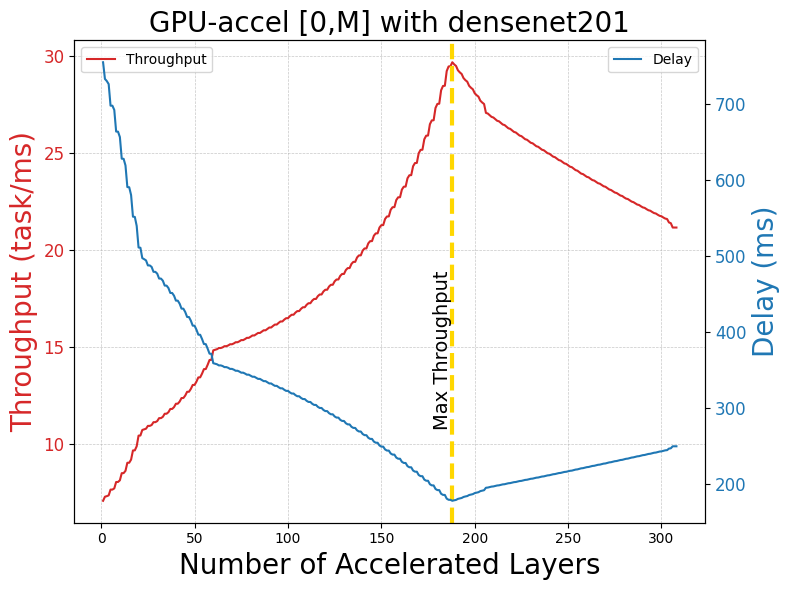

In [29]:
# num_accelerated_layer_list를 기준으로 정렬
sorted_data = sorted(zip(num_accelerated_layer_list, max_execution_time_list, throughput_list))

# 정렬된 데이터 분리
sorted_num_accelerated_layer_list, sorted_max_execution_time_list, sorted_throughput_list = zip(*sorted_data)

# MAX throughput과 그때의 delay 계산 및 출력
max_throughput = max(sorted_throughput_list)
max_throughput_index = sorted_throughput_list.index(max_throughput)
corresponding_delay = sorted_max_execution_time_list[max_throughput_index]
corresponding_delay_num_of_accelerated_layers = sorted_num_accelerated_layer_list[max_throughput_index]

print("MAX Throughput Index:", max_throughput_index)
print("MAX Throughput:", max_throughput)
print("Corresponding Number of Accelerated Layers:", corresponding_delay_num_of_accelerated_layers)
print("Corresponding Delay:", corresponding_delay)


# 2개의 y축을 가지는 그래프 생성
fig, ax1 = plt.subplots(figsize=(8, 6))

# 첫 번째 y축 (total_execution_time_list)
color = "tab:red"
ax1.set_ylabel("Throughput (task/ms)", color=color, size=20)
ax1.set_xlabel("Number of Accelerated Layers", size=20)

ax1.plot(sorted_num_accelerated_layer_list, sorted_throughput_list, color=color, linestyle="-", label="Throughput")
ax1.tick_params(axis="y", labelcolor=color, labelsize=12)
ax1.legend(loc="upper left")

# 두 번째 y축 (throughput_list)
ax2 = ax1.twinx()
color = "tab:blue"
ax2.set_xlabel("Layer index", size=20)
ax2.set_ylabel("Delay (ms)", color=color, size=20)
ax2.plot(sorted_num_accelerated_layer_list, sorted_max_execution_time_list, color=color, linestyle="-", label="Delay")
ax2.tick_params(axis="y", labelcolor=color, labelsize=12)
ax2.legend(loc="upper right")

ax1.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

ax1.axvline(x=corresponding_delay_num_of_accelerated_layers, color="gold", linewidth=3, linestyle="--")
ax1.text(corresponding_delay_num_of_accelerated_layers, np.max(sorted_throughput_list) / 2, "Max Throughput", color="black", rotation=90, 
         verticalalignment="center", horizontalalignment="right", fontsize=14)

plt.title(f"GPU-accel [0,M] with {model}", size=20)
plt.tight_layout()
plt.show()

# print("num_accelerated_layer_list: ", num_accelerated_layer_list)
# print("max_execution_time_list: ", max_execution_time_list)
# print("throughput_list: ", throughput_list)

##### 2. acceleration gain and block loss - glayers

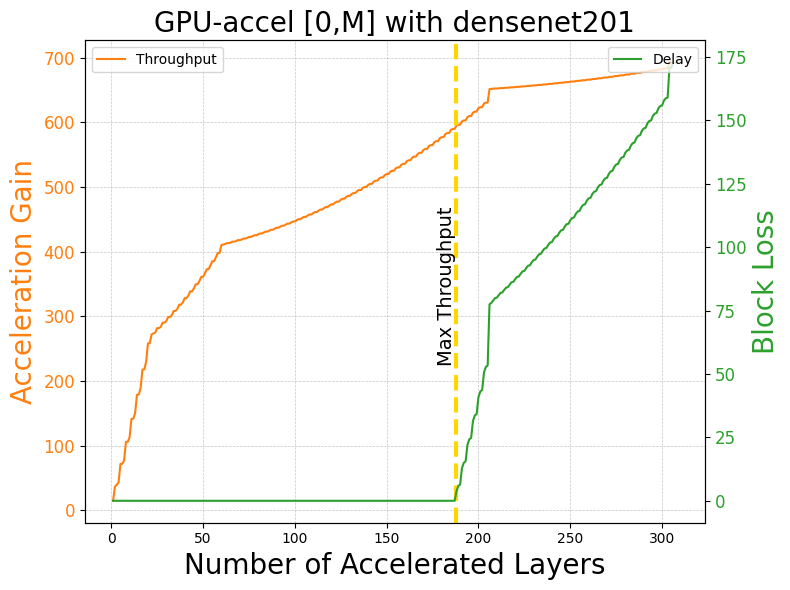

In [31]:
# num_accelerated_layer_list를 기준으로 정렬
sorted_data = sorted(zip(num_accelerated_layer_list, acceleration_gain_list, block_time_list))

# 정렬된 데이터 분리
sorted_num_accelerated_layer_list, sorted_acceleration_gain_list, sorted_block_time_list = zip(*sorted_data)

# 2개의 y축을 가지는 그래프 생성
fig, ax1 = plt.subplots(figsize=(8, 6))

# 첫 번째 y축 (total_execution_time_list)
color = "tab:orange"
ax1.set_ylabel("Acceleration Gain", color=color, size=20)
ax1.set_xlabel("Number of Accelerated Layers", size=20)

ax1.plot(sorted_num_accelerated_layer_list, sorted_acceleration_gain_list, color=color, linestyle="-", label="Throughput")
ax1.tick_params(axis="y", labelcolor=color, labelsize=12)
ax1.legend(loc="upper left")

# 두 번째 y축 (throughput_list)
ax2 = ax1.twinx()
color = "tab:green"
ax2.set_xlabel("Layer index", size=20)
ax2.set_ylabel("Block Loss", color=color, size=20)
ax2.plot(sorted_num_accelerated_layer_list, sorted_block_time_list, color=color, linestyle="-", label="Delay")
ax2.tick_params(axis="y", labelcolor=color, labelsize=12)
ax2.legend(loc="upper right")

ax1.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)
ax1.axvline(x=corresponding_delay_num_of_accelerated_layers, color="gold", linewidth=3, linestyle="--")
ax1.text(corresponding_delay_num_of_accelerated_layers, np.max(sorted_acceleration_gain_list) / 2, "Max Throughput", color="black", rotation=90, 
         verticalalignment="center", horizontalalignment="right", fontsize=14)

plt.title(f"GPU-accel [0,M] with {model}", size=20)
plt.tight_layout()
plt.show()

# print("num_accelerated_layer_list: ", num_accelerated_layer_list)
# print("acceleration_gain_list: ", sorted_acceleration_gain_list)
# print("block_time_list: ", sorted_block_time_list)

##### 3. net gain - glayers

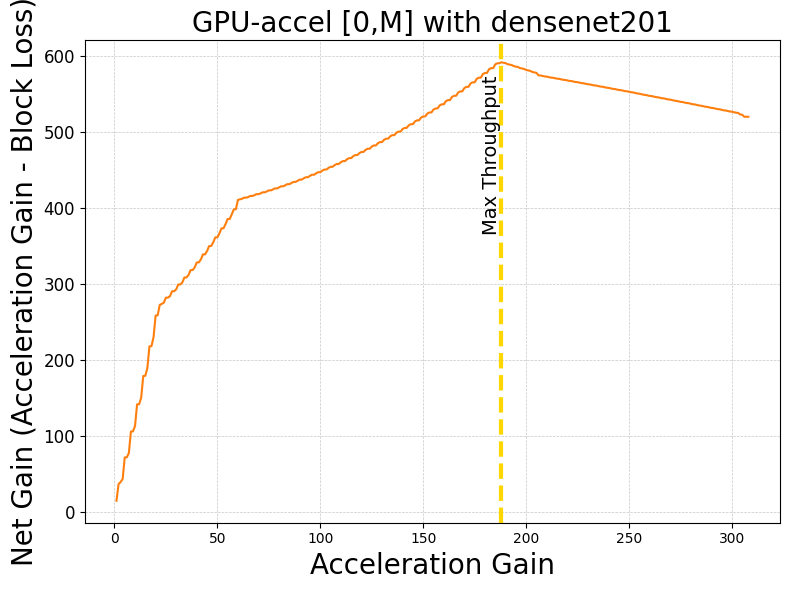

In [33]:
# num_accelerated_layer_list를 기준으로 정렬
sorted_data = sorted(zip(num_accelerated_layer_list, acceleration_gain_list, block_time_list))

# 정렬된 데이터 분리
sorted_num_accelerated_layer_list, sorted_acceleration_gain_list, sorted_block_time_list = zip(*sorted_data)
net_gain_list = [a - b for a, b in zip(sorted_acceleration_gain_list, sorted_block_time_list)]

# 2개의 y축을 가지는 그래프 생성
fig, ax1 = plt.subplots(figsize=(8, 6))

# 첫 번째 y축 (total_execution_time_list)
color = "tab:orange"
ax1.set_xlabel("Acceleration Gain", size=20)
ax1.set_ylabel("Net Gain (Acceleration Gain - Block Loss)", size=20)
ax1.plot(sorted_num_accelerated_layer_list, net_gain_list, color=color, linestyle="-", label="Throughput")
ax1.tick_params(axis="y", labelsize=12)

ax1.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

ax1.axvline(x=corresponding_delay_num_of_accelerated_layers, color="gold", linewidth=3, linestyle="--")
ax1.text(corresponding_delay_num_of_accelerated_layers, np.mean(net_gain_list), "Max Throughput", color="black", rotation=90, 
         verticalalignment="center", horizontalalignment="right", fontsize=14)


plt.title(f"GPU-accel [0,M] with {model}", size=20)
plt.tight_layout()
plt.show()

# print("num_accelerated_layer_list: ", num_accelerated_layer_list)
# print("net_gain_list: ", net_gain_list)

##### 4. throughput - delay

MAX Throughput Index: 187
MAX Throughput: 29.657261043446482
Corresponding Number of Accelerated Layers: 188
Corresponding Delay: 178.05177777778044


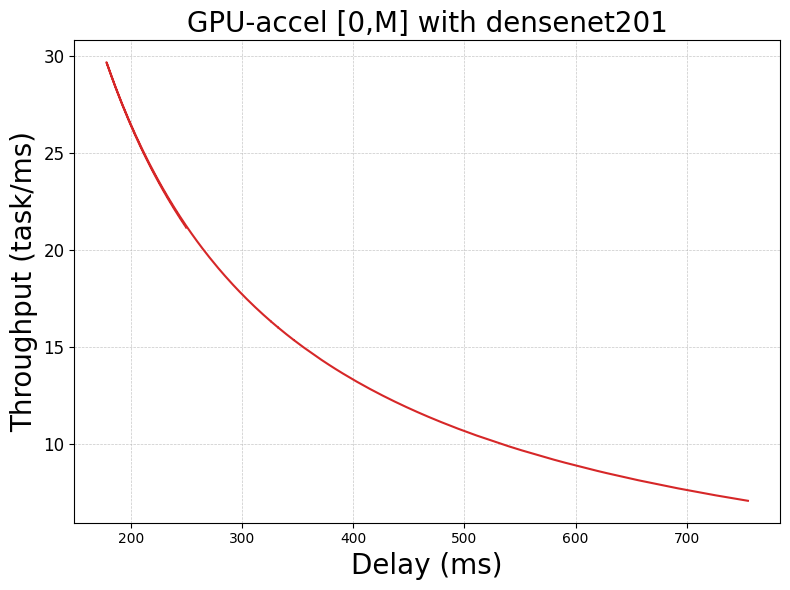

In [35]:
# num_accelerated_layer_list를 기준으로 정렬
sorted_data = sorted(zip(num_accelerated_layer_list, max_execution_time_list, throughput_list))

# 정렬된 데이터 분리
sorted_num_accelerated_layer_list, sorted_max_execution_time_list, sorted_throughput_list = zip(*sorted_data)

# MAX throughput과 그때의 delay 계산 및 출력
max_throughput = max(sorted_throughput_list)
max_throughput_index = sorted_throughput_list.index(max_throughput)
corresponding_delay = sorted_max_execution_time_list[max_throughput_index]
corresponding_delay_num_of_accelerated_layers = sorted_num_accelerated_layer_list[max_throughput_index]

print("MAX Throughput Index:", max_throughput_index)
print("MAX Throughput:", max_throughput)
print("Corresponding Number of Accelerated Layers:", corresponding_delay_num_of_accelerated_layers)
print("Corresponding Delay:", corresponding_delay)


# 2개의 y축을 가지는 그래프 생성
fig, ax1 = plt.subplots(figsize=(8, 6))

color = "tab:red"
ax1.set_ylabel("Throughput (task/ms)", size=20)
ax1.set_xlabel("Delay (ms)", size=20)
ax1.plot(sorted_max_execution_time_list, sorted_throughput_list, color=color, linestyle="-", label="Throughput")
ax1.tick_params(axis="y", labelsize=12)

ax1.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)


plt.title(f"GPU-accel [0,M] with {model}", size=20)
plt.tight_layout()
plt.show()

# print("num_accelerated_layer_list: ", num_accelerated_layer_list)
# print("max_execution_time_list: ", max_execution_time_list)
# print("throughput_list: ", throughput_list)

##### 5. block loss - acceleration gain

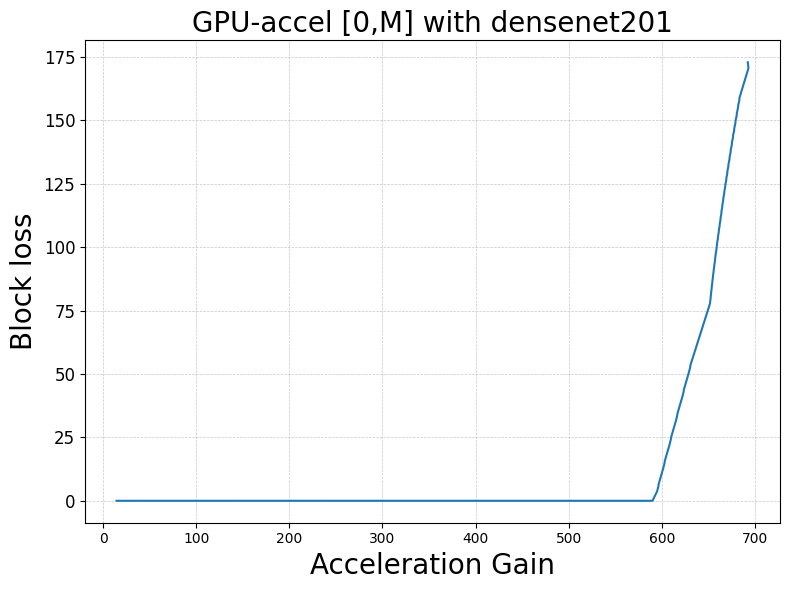

In [37]:
# num_accelerated_layer_list를 기준으로 정렬
sorted_data = sorted(zip(num_accelerated_layer_list, acceleration_gain_list, block_time_list))

# 정렬된 데이터 분리
sorted_num_accelerated_layer_list, sorted_acceleration_gain_list, sorted_block_time_list = zip(*sorted_data)

# 2개의 y축을 가지는 그래프 생성
fig, ax1 = plt.subplots(figsize=(8, 6))

# 첫 번째 y축 (total_execution_time_list)
color = "tab:blue"
ax1.set_ylabel("Block loss", size=20)
ax1.set_xlabel("Acceleration Gain", size=20)
ax1.plot(sorted_acceleration_gain_list, sorted_block_time_list, color=color, linestyle="-", label="Throughput")
ax1.tick_params(axis="y", labelsize=12)
ax1.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

plt.title(f"GPU-accel [0,M] with {model}", size=20)
plt.tight_layout()
plt.show()

# print("num_accelerated_layer_list: ", num_accelerated_layer_list)
# print("acceleration_gain_list: ", sorted_acceleration_gain_list)
# print("block_time_list: ", sorted_block_time_list)